# This GNN let you know if a graph has a Hamiltonian Cycle

In [1]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from time import time

In [3]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [4]:
%run utils.ipynb     #this is were my function was stored

In [5]:
def gen_q_dict_hamiltonian_cycle(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for Hamiltonian Cycle as a maximization problem.
    
    Input:
        nx_G: graph as a NetworkX graph object
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get a penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = -penalty

    # all diagonal terms get a reward
    for u in nx_G.nodes:
        Q_dic[(u, u)] = penalty

    return Q_dic

In [6]:
def postprocess_gnn_hamiltonian_cycle(best_bitstring, nx_graph):
    """
    Helper function to postprocess Hamiltonian Cycle results from GNN.

    Input:
        best_bitstring: bitstring as torch tensor
        nx_graph: networkx Graph object
    Output:
        has_hamiltonian_cycle: True if a Hamiltonian cycle is found, False otherwise
        cycle_nodes: Order of nodes in the Hamiltonian cycle (list of integers)
    """

    # Convert the best bitstring tensor to a list
    bitstring_list = list(best_bitstring)

    # Extract the order of nodes in the cycle based on active bits
    cycle_nodes = [node for node, entry in enumerate(bitstring_list) if entry == 1]

    # Check if the cycle is valid (i.e., includes all nodes and forms a cycle)
    has_hamiltonian_cycle = False
    if len(cycle_nodes) == nx_graph.number_of_nodes() and nx_graph.has_edge(cycle_nodes[-1], cycle_nodes[0]):
        has_hamiltonian_cycle = True

    return has_hamiltonian_cycle, cycle_nodes

In [7]:
# Graph hypers
n = 100
d = 5
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 100

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

In [8]:
# Constructs a random d-regular or p-probabilistic graph

nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)


# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph

q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_hamiltonian_cycle(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)


Generating d-regular graph with n=100, d=5, seed=1


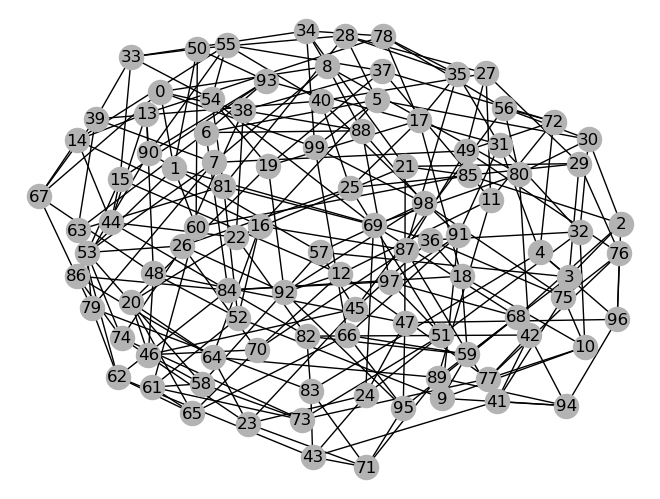

In [9]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [10]:
# Establish pytorch GNN + optimizer for Hamiltonian Cycle
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': n,  # Number of nodes in the graph for Hamiltonian Cycle
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)


In [11]:
print('Running GNN...')
gnn_start = time()
                                           #########  Función en utils #######
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: -77.83918762207031
Epoch: 1000, Loss: -115.0953369140625
Epoch: 2000, Loss: -220.7073974609375
Epoch: 3000, Loss: -281.318115234375
Epoch: 4000, Loss: -294.189453125
Epoch: 5000, Loss: -297.7002258300781
Epoch: 6000, Loss: -298.9682922363281
Epoch: 7000, Loss: -299.50048828125
Epoch: 8000, Loss: -299.7459716796875
Epoch: 9000, Loss: -299.8666076660156
Epoch: 10000, Loss: -299.9284362792969
Stopping early on epoch 10145 (patience: 100)
GNN training (n=100) took 83.572
GNN final continuous loss: -299.9344787597656
GNN best continuous loss: -299.9344787597656


In [12]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN for Hamiltonian Cycle
has_hamiltonian_cycle, cycle_nodes = postprocess_gnn_hamiltonian_cycle(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

if has_hamiltonian_cycle:
    print(f'Hamiltonian Cycle found by GNN with nodes: {cycle_nodes}')
    print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')
else:
    print('No Hamiltonian Cycle found by GNN')


Hamiltonian Cycle found by GNN with nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Took 83.631s, model training took 83.595s


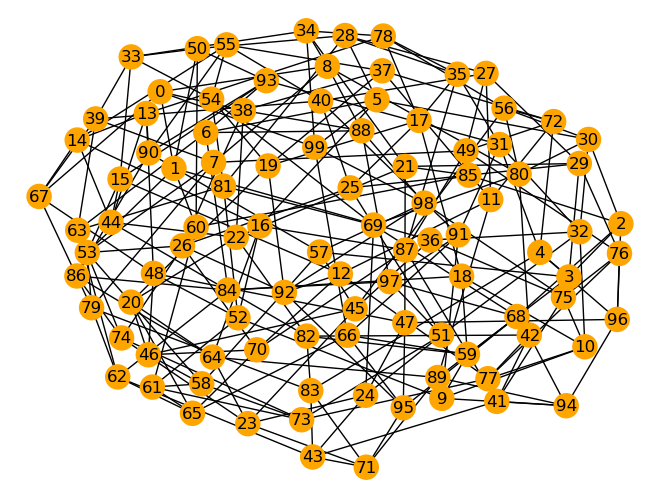

In [13]:
# Visualize result for Hamiltonian Cycle
color_map = ['orange' if node in cycle_nodes else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)
